# Analysis of Stack Overflow Survey Attitudes on Diversity

### Table of Contents
1. [Business Understanding](#1.-Business-Understanding)


2. [Data Understanding](#2.-Data-Understanding)
    
    2.1. [Inspect `DiversityImportant` Column](#2.1-Inspect-DiversityImportant-Column)
    
    2.2. [Explore `DiversityImportant` Correlations](#2.2.-Explore-DiversityImportant-Correlations)
    
    
3. [Prepare Data](#3.-Prepare-Data)

### 1. Business Understanding
This analysis is motivated by the following business question:
* What if any factors can predict attitudes about diversity in the workplace?

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns
import os
import pprint
import itertools
import scipy.stats as ss
import column_rename_dicts as crd
from so_analysis_functions import collapse_cat_and_dummy, get_description, df_missingness_stats, recode_null_not_null_as_0_1

%matplotlib inline
pd.options.display.max_seq_items = 500

In [29]:
#regex patterns needed in data cleaning
date_pattern = r"^([1-9]|1[012])[- /.]([1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$"

In [30]:
#Load Data
df_2017 = pd.read_csv('./so-survey-2017/survey_results_public.csv')
schema_2017 = pd.read_csv('./so-survey-2017/survey_results_schema.csv')

#### What if any factors can predict attitudes about diversity in the workplace?

### 2. Data Understanding
We will focus on the column: `DiversityImportant`, 
which corresponds to the following question:

> Diversity in the workplace is important

In [31]:
df_missingness_stats(df_2017, '2017')

Number of Rows in 2017 data: 51392
Number of Columns in 2017 data: 154
Number of Columns in 2017 data with no missing values: 7
Number of Columns in 2017 data with > 75% missing values: 14
Number of Columns in 2017 data with all missing values: 0
Columns in 2017 data with no missing values: {'Respondent', 'ProgramHobby', 'FormalEducation', 'Country', 'EmploymentStatus', 'Professional', 'University'}
Columns in 2017 data with > 75% missing values: {'NonDeveloperType', 'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExCoderReturn', 'WebDeveloperType', 'ExCoderActive', 'ExCoderBalance', 'ExCoder10Years', 'ExpectedSalary', 'MobileDeveloperType', 'ExCoderNotForMe', 'YearsCodedJobPast', 'TimeAfterBootcamp'}


#### 2.1 Inspect `DiversityImportant` Column

In [32]:
df_2017['DiversityImportant'].value_counts(dropna=False)

NaN                  20489
Agree                12011
Strongly agree        8022
Somewhat agree        7363
Disagree              2327
Strongly disagree     1180
Name: DiversityImportant, dtype: int64

Text(0.5, 1.0, "Agree/Disagree with the statement that 'Diversity in the workplace is important'")

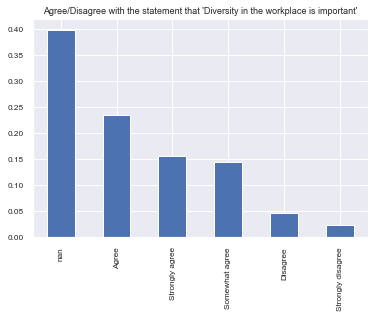

In [33]:
diversity_importance_value_counts = df_2017['DiversityImportant'].value_counts(dropna=False)
(diversity_importance_value_counts/df_2017.shape[0]).plot(kind="bar")
plt.title("Agree/Disagree with the statement that 'Diversity in the workplace is important'")

In [34]:
# Since the DiversityImportant Column is our variable of interest
# we can drop any rows where it is missing
df_2017 = df_2017.dropna(subset = ['DiversityImportant'])

Text(0.5, 1.0, "Agree/Disagree with the statement that 'Diversity in the workplace is important'")

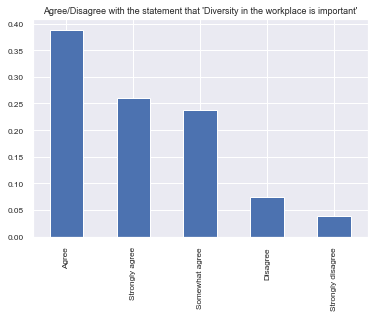

In [57]:
diversity_importance_value_counts = df_2017['DiversityImportant'].value_counts(dropna=False)
(diversity_importance_value_counts/df_2017.shape[0]).plot(kind="bar")
plt.title("Agree/Disagree with the statement that 'Diversity in the workplace is important'")

In [39]:
df_2017_1 = df_2017.drop(
    columns=['CareerSatisfaction', 
    'JobSatisfaction', 
    'HoursPerWeek',
    'StackOverflowSatisfaction', 
    'Salary', 
    'ExpectedSalary',
    "Respondent",
    "PronounceGIF",
    "CousinEducation",
    "HaveWorkedLanguage",
    "WantWorkLanguage",
    "HaveWorkedFramework",
    "WantWorkFramework",
    "HaveWorkedDatabase",
    "WantWorkDatabase",
    "HaveWorkedPlatform",
    "WantWorkPlatform",
    "IDE",
    "VersionControl",
    "CheckInCode",
    "EquipmentSatisfiedMonitors",
    "EquipmentSatisfiedCPU",
    "EquipmentSatisfiedRAM",
    "EquipmentSatisfiedStorage",
    "EquipmentSatisfiedRW",
    "InfluenceInternet",
    "InfluenceWorkstation",
    "InfluenceHardware",
    "InfluenceServers",
    "InfluenceTechStack",
    "InfluenceDeptTech",
    "InfluenceVizTools",
    "InfluenceDatabase",
    "InfluenceCloud",
    "InfluenceConsultants",
    "InfluenceRecruitment",
    "InfluenceCommunication",
    "StackOverflowDescribes",
    "StackOverflowSatisfaction",
    "StackOverflowDevices",
    "StackOverflowFoundAnswer",
    "StackOverflowCopiedCode",
    "StackOverflowJobListing",
    "StackOverflowCompanyPage",
    "StackOverflowJobSearch",
    "StackOverflowNewQuestion",
    "StackOverflowAnswer",
    "StackOverflowMetaChat",
    "StackOverflowAdsRelevant",
    "StackOverflowAdsDistracting",
    "StackOverflowModeration",
    "StackOverflowCommunity",
    "StackOverflowHelpful",
    "StackOverflowBetter",
    "StackOverflowWhatDo",
    "StackOverflowMakeMoney",
    "SurveyLong",
    "QuestionsInteresting",
    "QuestionsConfusing",
    "InterestedAnswers"
    ]
    )

#### 2.2. Explore `DiversityImportant` Correlations

`cramers_corrected_stat(confusion_matrix)` function source:
https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features

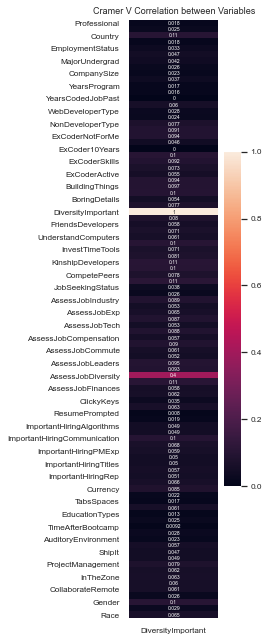

In [40]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    try:
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r,k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

    except ValueError:
        pass
        



cols = list(df_2017_1.columns)
corrM = np.zeros((len(cols), 1))
# there's probably a nice pandas way to do this
for col1 in cols:
    idx1 = cols.index(col1)
    corrM[idx1, 0] = cramers_corrected_stat(pd.crosstab(df_2017_1['DiversityImportant'], df_2017_1[col1]))
    

corr = pd.DataFrame(corrM, index=cols, columns=['DiversityImportant'])
fig, ax = plt.subplots(figsize=(2, 11))
sns.set(font_scale=.75)
ax = sns.heatmap(corr, annot=True, ax=ax, annot_kws={"size": 5}); 
ax.set_title("Cramer V Correlation between Variables");

In [41]:
corr.sort_values(by='DiversityImportant', ascending=False)[1:11]

,DiversityImportant
AssessJobDiversity,0.401460
ChangeWorld,0.111006
AssessJobProduct,0.106984
KinshipDevelopers,0.106110
Country,0.105216
ExCoderBelonged,0.104378
SeriousWork,0.103858
ChallengeMyself,0.103548
Gender,0.103246
LearningNewTech,0.099870


In [55]:
corr.sort_values(by='DiversityImportant', ascending=True)[1:20]

,DiversityImportant
YearsCodedJobPast,0.000000
ResumePrompted,0.007955
TimeAfterBootcamp,0.009157
EducationTypes,0.013014
YearsCodedJob,0.016126
YearsProgram,0.016965
TabsSpaces,0.017065
Professional,0.018283
University,0.018404
LearnedHiring,0.019428


Let's focus on the columns above. Below are the column names and the corresponding question text: 

| Column | Question |
| ------ | ------ |
| `AssessJobDiversity` | When you're assessing potential jobs to apply to, how important are each of the following to you? The diversity of the company or organization. |
| `ChangeWorld` | I want to change the world. |
| `AssessJobProduct` | When you're assessing potential jobs to apply to, how important are each of the following to you? How widely used or impactful the product or service I'd be working on is. |
| `KinshipDevelopers` | I feel a sense of kinship to other developers. |
| `Country` | In which country do you currently live? |
| `ExCoderBelonged` | You said before that you used to code as part of your job, but no longer do. To what extent do you agree or disagree with the following statements? When I was a developer, I didn't feel like I belonged with my colleagues. |
| `SeriousWork` | I take my work very seriously. |
| `ChallengeMyself` | I like to challenge myself. |
| `Gender` | Which of the following do you currently identify as? |
| `LearningNewTech` | Learning new technologies is fun. |

In [56]:
df_2017['AssessJobDiversity'].value_counts(dropna=False)

NaN                     15859
Somewhat important       4662
Important                3979
Not very important       3256
Not at all important     1684
Very important           1463
Name: AssessJobDiversity, dtype: int64

In [43]:
df_2017['ChangeWorld'].value_counts(dropna=False)

Agree                9016
Somewhat agree       8890
Strongly agree       7079
Disagree             4356
Strongly disagree     974
NaN                   588
Name: ChangeWorld, dtype: int64

In [44]:
df_2017['AssessJobProduct'].value_counts()

Important               5388
Somewhat important      4825
Very important          2231
Not very important      2123
Not at all important     475
Name: AssessJobProduct, dtype: int64

In [45]:
df_2017['Country'].value_counts(dropna=False).head(15)

United States         7423
United Kingdom        2758
India                 2686
Germany               2463
Canada                1419
France                1004
Poland                 772
Australia              605
Netherlands            531
Russian Federation     523
Spain                  500
Brazil                 480
Italy                  471
Sweden                 396
Switzerland            356
Name: Country, dtype: int64

In [46]:
df_2017['ExCoderBelonged'].value_counts(dropna=False)

NaN                  30331
Disagree               198
Strongly disagree      194
Somewhat agree          85
Agree                   66
Strongly agree          29
Name: ExCoderBelonged, dtype: int64

In [47]:
df_2017['SeriousWork'].value_counts(dropna=False)

Agree                14809
Strongly agree       10112
Somewhat agree        4914
Disagree               788
Strongly disagree      149
NaN                    131
Name: SeriousWork, dtype: int64

In [48]:
df_2017['ChallengeMyself'].value_counts(dropna=False)

Agree                14316
Strongly agree       11635
Somewhat agree        3762
NaN                    570
Disagree               508
Strongly disagree      112
Name: ChallengeMyself, dtype: int64

In [49]:
df_2017['ChangeWorld'].value_counts(dropna=False)

Agree                9016
Somewhat agree       8890
Strongly agree       7079
Disagree             4356
Strongly disagree     974
NaN                   588
Name: ChangeWorld, dtype: int64

In [50]:
df_2017['DiversityImportant_missing'] = df_2017['DiversityImportant'].isna()
df_2017['ChangeWorld_missing'] = df_2017['ChangeWorld'].isna()
df_2017['AssessJobProduct_missing'] = df_2017['AssessJobProduct'].isna()
df_2017['KinshipDevelopers_missing'] = df_2017['KinshipDevelopers'].isna()
df_2017['Country_missing'] = df_2017['Country'].isna()
df_2017['ExCoderBelonged_missing'] = df_2017['ExCoderBelonged'].isna()
df_2017['SeriousWork_missing'] = df_2017['SeriousWork'].isna()
df_2017['ChallengeMyself_missing'] = df_2017['ChallengeMyself'].isna()
df_2017['Gender_missing'] = df_2017['Gender'].isna()
df_2017['LearningNewTech_missing'] = df_2017['LearningNewTech'].isna()

In [51]:
corr_matrix = df_2017[['DiversityImportant_missing'
                       , 'ChangeWorld_missing'
                       , 'AssessJobProduct_missing'
                       , 'KinshipDevelopers_missing'
                       , 'Country_missing'
                       , 'ExCoderBelonged_missing'
                       , 'SeriousWork_missing'
                       , 'ChallengeMyself_missing'
                       , 'Gender_missing'
                       , 'LearningNewTech_missing'
                      ]
                     ].corr()

In [52]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

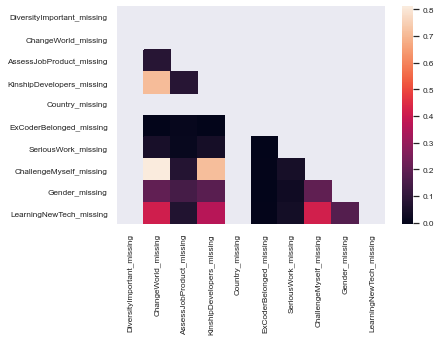

In [53]:
sns.heatmap(corr_matrix, mask=mask)

In [54]:
corr_matrix

,DiversityImportant_missing,ChangeWorld_missing,AssessJobProduct_missing,KinshipDevelopers_missing,Country_missing,ExCoderBelonged_missing,SeriousWork_missing,ChallengeMyself_missing,Gender_missing,LearningNewTech_missing
DiversityImportant_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChangeWorld_missing,NaN,1.000000,0.081605,0.711766,NaN,-0.003719,0.049243,0.811773,0.200831,0.414334
AssessJobProduct_missing,NaN,0.081605,1.000000,0.079703,NaN,0.008924,0.014712,0.074313,0.143472,0.069127
KinshipDevelopers_missing,NaN,0.711766,0.079703,1.000000,NaN,-0.004139,0.040578,0.714156,0.186428,0.364134
Country_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExCoderBelonged_missing,NaN,-0.003719,0.008924,-0.004139,NaN,1.000000,-0.002126,-0.000802,-0.001615,0.001405
SeriousWork_missing,NaN,0.049243,0.014712,0.040578,NaN,-0.002126,1.000000,0.046580,0.028715,0.039482
ChallengeMyself_missing,NaN,0.811773,0.074313,0.714156,NaN,-0.000802,0.046580,1.000000,0.198843,0.418921
Gender_missing,NaN,0.200831,0.143472,0.186428,NaN,-0.001615,0.028715,0.198843,1.000000,0.176137
LearningNewTech_missing,NaN,0.414334,0.069127,0.364134,NaN,0.001405,0.039482,0.418921,0.176137,1.000000


### 3. Prepare Data
Recoding these columns according to 'strict/lax' criteria in preparation for modeling.

In [25]:
def recode_agree_cat(var):
    return df_2017[var].apply(collapse_cat_and_dummy, args=(["Strongly agree", "Agree"],)), df_2017[var].apply(collapse_cat_and_dummy, args=(["Strongly agree", "Agree", "Somewhat agree"],))

In [58]:
df_2017['DivImp_Strict'], df_2017['DivImp_Lax'] = recode_agree_cat('DiversityImportant')
df_2017['ChangeWorld_Strict'], df_2017['ChangeWorld_Lax'] = recode_agree_cat('ChangeWorld')
df_2017['AssessJobProduct_Strict'], df_2017['AssessJobProduct_Lax'] = recode_agree_cat('AssessJobProduct')
df_2017['KinshipDevelopers_Strict'], df_2017['KinshipDevelopers_Lax'] = recode_agree_cat('KinshipDevelopers')
df_2017['Country_Strict'], df_2017['Country_Lax'] = recode_agree_cat('Country')
df_2017['ExCoderBelonged_Strict'], df_2017['ExCoderBelonged_Lax'] = recode_agree_cat('ExCoderBelonged')
df_2017['SeriousWork_Strict'], df_2017['SeriousWork_Lax'] = recode_agree_cat('SeriousWork')
df_2017['ChallengeMyself_Strict'], df_2017['ChallengeMyself_Lax'] = recode_agree_cat('ChallengeMyself')
df_2017['Gender_Strict'], df_2017['Gender_Lax'] = recode_agree_cat('Gender')
df_2017['LearningNewTech_Strict'], df_2017['LearningNewTech_Lax'] = recode_agree_cat('LearningNewTech')

In [59]:
df_2017_strict = df_2017[ ['DivImp_Strict',
                          'ChangeWorld_Strict',
                          'AssessJobProduct_Strict',
                          'KinshipDevelopers_Strict',
                          'Country_Strict',
                          'ExCoderBelonged_Strict',
                          'SeriousWork_Strict',
                          'ChallengeMyself_Strict',
                          'Gender_Strict',
                          'LearningNewTech_Strict',
                         ]]


In [60]:
y_strict = df_2017['DivImp_Strict']
X_strict = df_2017[['ChangeWorld_Strict',
                    'AssessJobProduct_Strict',
                    'KinshipDevelopers_Strict',
                    'Country_Strict',
                    'ExCoderBelonged_Strict',
                    'SeriousWork_Strict',
                    'ChallengeMyself_Strict',
                    'Gender_Strict',
                    'LearningNewTech_Strict'
                   ]
                  ]

In [61]:
y_lax = df_2017['DivImp_Lax']
X_lax = df_2017[['ChangeWorld_Lax',
                    'AssessJobProduct_Lax',
                    'KinshipDevelopers_Lax',
                    'Country_Lax',
                    'ExCoderBelonged_Lax',
                    'SeriousWork_Lax',
                    'ChallengeMyself_Lax',
                    'Gender_Lax',
                    'LearningNewTech_Lax'
                   ]
                  ]

### 4. Data Modeling

The function below will generate testing/training splits and compare different classifiers

In [62]:
# Split dataset into training set and test set
def compare_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test


    #Create a Gaussian Classifier
    gnb = GaussianNB()

    #Train the model using the training sets
    gnb.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_gnb = gnb.predict(X_test)

    # Logistic Regression Classifier
    logreg = LogisticRegression()

    #Train the model using the training sets
    logreg.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_lr = logreg.predict(X_test)

    # Random Forest Classifier
    rf = RandomForestClassifier()

    #Train the model using the training sets
    rf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_rf = rf.predict(X_test)

    # Adaboost Classifier
    ada = AdaBoostClassifier()

    #Train the model using the training sets
    ada.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_ada = ada.predict(X_test)

    print("GNB Accuracy:",metrics.accuracy_score(y_test, y_pred_gnb))

    print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

    print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

    print("AdaBoost Accuracy:",metrics.accuracy_score(y_test, y_pred_ada))


In [63]:
compare_classifiers(X_strict, y_strict)

GNB Accuracy: 0.6271168158774674
Logistic Regression Accuracy: 0.6522489483335131
Random Forest Accuracy: 0.6506309998921368
AdaBoost Accuracy: 0.6522489483335131


In [64]:
compare_classifiers(X_lax, y_lax)

GNB Accuracy: 0.8303311401143351
Logistic Regression Accuracy: 0.8851256606622803
Random Forest Accuracy: 0.8862042929565311
AdaBoost Accuracy: 0.8851256606622803
